# Time Series Analysis

This notebook estimates autocorrelations and different time series models (AR, MA and VAR).

## Load Packages and Extra Functions

The key functions in this notebook are from the (local) `FinEcmt_TimeSeries` module, but we also use [StatsBase.jl](https://github.com/JuliaStats/StatsBase.jl) package for estimating autocorrelations. 

In [1]:
MyModulePath = joinpath(pwd(),"src")
!in(MyModulePath,LOAD_PATH) && push!(LOAD_PATH,MyModulePath)
using FinEcmt_OLS, FinEcmt_TimeSeries
using FinEcmt_MLEGMM: MLE

In [2]:
#=
include(joinpath(pwd(),"src","FinEcmt_OLS.jl"))
include(joinpath(pwd(),"src","FinEcmt_TimeSeries.jl"))
using .FiniteDiff: finite_difference_hessian as hessian, finite_difference_jacobian as jacobian
using .FinEcmt_OLS, .FinEcmt_TimeSeries
using .FinEcmt_MLEGMM: MLE
=#

In [3]:
using DelimitedFiles, LinearAlgebra, Distributions, StatsBase

In [4]:
using Plots
default(size = (480,320),fmt = :png)

## Load Data

In [5]:
xx      = readdlm("Data/RvSP500.csv",',',skipstart=1)
y_data  = xx[:,3]            #SP500 log realized monthly volatility
xx      = nothing

T   = size(y_data,1)
println("Sample size: $T")

Sample size: 574


# Descriptive Statistics

## Autocorrelations

The $s\text{th}$ autocorrelation $\rho_s$ is the correlation of $y_{t}$ and $y_{t-s}$. It is a useful tool for describing the properties of data.

It can be shown that the t-stat of an autocorrelation is $\sqrt{T} \rho_s$.

We can (jointly) test the first $L$ autocorrelations by the Box-Pierce test, which (under the null hypothesis of no autocorrelation) has a $\chi^2_L$ distribution.

In [6]:
L = 5
lags = 1:L
ρ_data = autocor(y_data,lags)         #using the StatsBase package

printblue("Autocorrelations:\n")
printmat(ρ_data,sqrt(T)*ρ_data;colNames=["autocorrr","t-stat"],rowNames=lags,cell00="lag")

BP = T*sum(ρ_data.^2)            #the Box-Pierce test statistic

printblue("Box-Pierce test:\n")
printmat(BP,quantile(Chisq(L),0.9);rowNames=["test statistic","10% critical value"])

Autocorrelations:

lag autocorrr    t-stat
1       0.709    16.982
2       0.602    14.419
3       0.529    12.684
4       0.459    11.000
5       0.455    10.903

Box-Pierce test:

test statistic       897.040     9.236



# AR(p)

This section discusses the properties and estimation of autoregressive (AR) processes.

## Rewriting an AR(p) as a VAR(1)

An easy way to do AR(p) calculation is to first transform the AR(p) to a VAR(1) (also called companion form) and then apply the rather straightforward formulas for VAR(1) models.

For instance, an AR(2)

$y_t = a_1 y_{t-1} + a_2 y_{t-2} + \epsilon_t.$

can be written as a 2-variable VAR(1) 

$x_t = A_1 x_{t-1} + u_t,$

where 

$x_t = 
\begin{bmatrix} 
y_t \\ 
y_{t-1}  
\end{bmatrix} 
\text{ and }
A_1 = 
\begin{bmatrix} 
a_1 & a_2\\ 
1 & 0 
\end{bmatrix}.$

This is done in the `CompanionFormAR(a)` function.

In [7]:
(a₁,a₂) = (0.85,-0.5)                  #AR(2)
(A,Ω) = CompanionFormAR([a₁,a₂])       #A and the Var(shocks)

([0.85 -0.5; 1.0 0.0], [1.0 0.0; 0.0 0.0])

## Impulse Response Function of an AR Process

The next cell shows how a shock to an AR process propagates over time, the *impulse response function* (IRF). For *stationary models*, the effect of a shock eventually disappears.

The IRF can be calculated by an explicit loop for the specific model. We do that below in order to show the basic idea. As a comparison, we apply the approach of first transforming to a VAR(1) and then using the simple formulas for that model

$ 
\partial x_{t+s}/\partial u_{j,t} = A^s e_j,
$
where is a vector of zeros, except that element $j$ is one. The function `VAR1IRF()` (from local module) does this.

(The `ARMAFilter()` function could also be used but this is not done here.)

The models used here is an AR(2)

$y_t = a_1 y_{t-1} + a_2 y_{t-2} + \epsilon_t.$

In [8]:
t_max = 15                #calculations by a simple loop

ϵ    = zeros(t_max)
ϵ[1] = 1                  #a single shock

y = copy(ϵ)
y[1] = ϵ[1]               #setting a₁*y[0] + a₂*y[-1] =0
y[2] = a₁*y[1] + ϵ[2]     #setting a₂*y[0] = 0
for t in 3:t_max
    y[t] = a₁*y[t-1] + a₂*y[t-2] + ϵ[t]
end

In [9]:
irf_ar2 = VAR1IRF(A,t_max-1;m=1);     #same, but using VAR(1) function  
                                      #m=1 to pick out results for only 1 variable
#irf_ar2_ = ARMAFilter(ϵ,[a₁,a₂],[])
#printmat(y,irf_ar2,irf_ar2_)

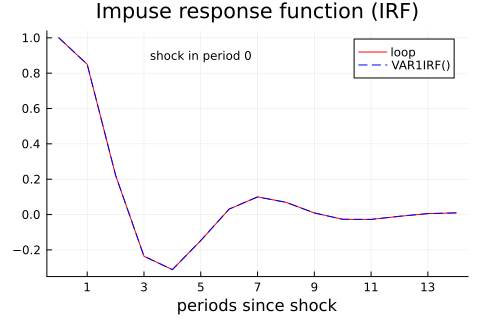

In [10]:
p1 = plot( 0:t_max-1,[y irf_ar2],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           label = ["loop" "VAR1IRF()"],
           xticks = 1:2:t_max,
           xlabel = "periods since shock",
           title = "Impuse response function (IRF)",
           annotation = (5,0.9,text("shock in period 0",8)) )
display(p1)

## Autocorrelations Implied by an AR Process

by using `VAR1AutoCov()` (from local module)

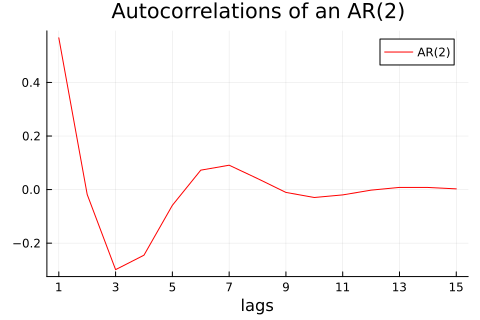

In [11]:
(_,_,ρ_ar2) = VAR1AutoCov(A,t_max;m=1)     #implied autocorrelations

p1 = plot( 1:t_max,ρ_ar2,
           label = "AR(2)",
           linecolor = :red,
           linestyle = :solid,
           xticks = 1:2:t_max,
           xlabel = "lags",
           title = "Autocorrelations of an AR(2)" )
display(p1)

## Estimation of an AR Process

AR models can be estimated by OLS. 

The `ARpEst(y,p)` function (from local module) provides a simple way of doing this.

In [12]:
#@doc2 ARpEst

#using CodeTracking
#println(@code_string ARpEst([1],2))    #print the source code

In [13]:
aAR1_data = ARpEst(y_data,1)
aAR2_data = ARpEst(y_data,2)
printlnPs("Estimated AR(1) coef: ",aAR1_data)
printlnPs("Estimated AR(2) coefs: ",aAR2_data)

Estimated AR(1) coef:      0.713
Estimated AR(2) coefs:      0.569     0.204


## More Descriptive Statistics: Partial Autocorrelations

The partial autocorrelation coefficient is the regression coefficients on $x_{t-p}$ in an AR(p) regression, that is, on the last regressor. It is a useful tool for describing the properties of your data.

In [14]:
pac_data = pacf(y_data,lags)        #from the StatsBase package

printblue("autocorrelations and  partial autocorrelations:\n")
printmat(ρ_data,pac_data;colNames=["autocorr","pac"],rowNames=lags,cell00="lag")

printred("ρ_data[1] and pac_data[1] are very similar: in a large sample they would be almost the same")

autocorrelations and  partial autocorrelations:

lag  autocorr       pac
1       0.709     0.713
2       0.602     0.204
3       0.529     0.103
4       0.459     0.031
5       0.455     0.130

ρ_data[1] and pac_data[1] are very similar: in a large sample they would be almost the same


## The Roots of an AR Model (extra)

The *roots* of an AR(p) is a formal way of determining whether it is stationary. (An informal way is to check whether the impulse response function goes to zero as the horizon is extended.)

An easy way to calculate the roots is to first transform the AR(p) to a VAR(1) and then calculate the eigenvalues. If their absolute values are lower than one, then the model is stationary.

In [15]:
λ = eigen(A).values                #eigenvalues of the companion form

println("absolute values of the eigenvalues: should be < 1 for stationarity")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for stationarity
     0.707
     0.707



## Forecasting with an AR Process

Forecasts can be calculated in several ways. The perhaps easiest approach is to use the VAR(1) form and notice that 
$\mathrm{E}_t x_{t+s} = A^s x_t.$

The `VAR1Forecast()` (from local module) implements this.

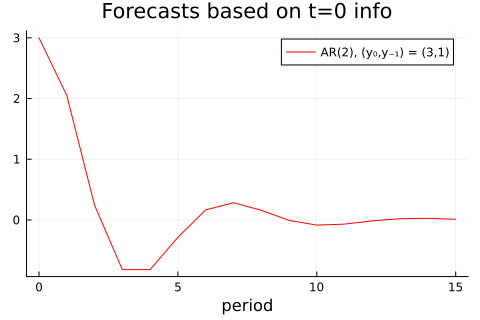

In [16]:
x_initial = [3,1]    #x[0],x[-1]

Ex, = VAR1Forecast(x_initial,A,t_max;m=1)       #applying VAR(1) function

p1 = plot( 0:t_max,Ex,
           label = "AR(2), (y₀,y₋₁) = (3,1)",
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xlabel = "period",
           title = "Forecasts based on t=0 info" )
display(p1)

# VAR(p)

This section some of the calculations for vector autoregressive (VAR) processes. 
Formally, this is very similar to the computations for the AR($p$) above, since we 
used the approach of converting the AR() model to a VAR(1). However, there is one key
difference: we are now interested in the results for more than one (the first) 
variable.

To illustrate this, consider a VAR(2)

$y_t = A_1 y_{t-1} + A_2 y_{t-2} + \epsilon_t,$

where $y_t$ and $y_{t-1}$ are vectors with two elements and

$A_1 = 
\begin{bmatrix} 
0.5 & 0.2\\ 
0.1 & -0.3 
\end{bmatrix}$

$A_2 = 
\begin{bmatrix} 
0.1 & 0.1\\ 
0.1 & 0.2 
\end{bmatrix}$

(You may want to change $A_2$ to a matrix of zeros to compare with the results in the lecture notes.)

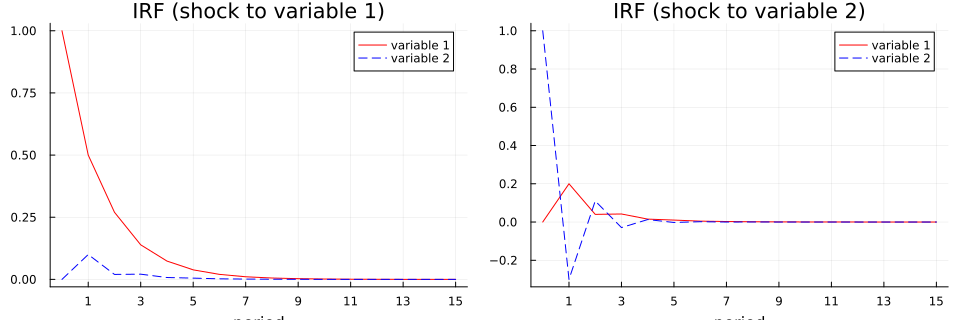

In [17]:
A1 = [0.5 0.2;
      0.1 -0.3]
A2 = [0.1 0.1;
      0.1 0.2]
A2 = zeros(2,2)

Ap = cat(A1,A2,dims=3)
A, = CompanionFormVAR(Ap)             #convert VAR(2) to larger VAR(1)
irf_var2 = VAR1IRF(A,t_max;m=2)          

p1 = plot( 0:t_max,irf_var2[:,:,1],
           label = ["variable 1" "variable 2"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = 1:2:t_max,
           xlabel = "period",
           title = "IRF (shock to variable 1)" )

p2 = plot( 0:t_max,irf_var2[:,:,2],
           label = ["variable 1" "variable 2"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = 1:2:t_max,
           xlabel = "period",
           title = "IRF (shock to variable 2)" )

p = plot(p1,p2,layout=(1,2),size=(480*2,320))
display(p)

# Non-Stationary Processes

The cells below shows the impulse response function and the roots of a non-stationary AR(3).

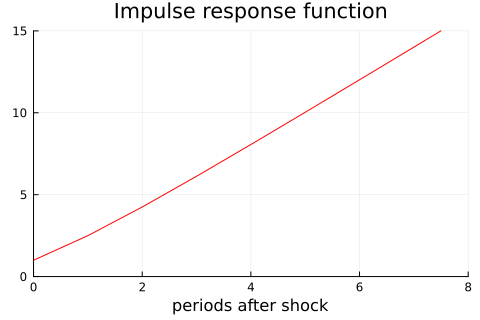

In [18]:
a = [2.5,-2,0.5]                      #AR(3) coefficients
A, = CompanionFormAR(a)

irf_ar3 = VAR1IRF(A,t_max-1;m=1)

p1 = plot( 0:t_max-1,irf_ar3,
           label = "",
           linecolor = :red,
           #xticks = 1:2:t_max,
           ylims = (0,15),
           xlims = (0,8),
           xlabel = "periods after shock",
           title = "Impulse response function" )
display(p1)

In [19]:
λ = eigen(A).values    #eigenvalues of the companion form

println("absolute values of the eigenvalues: should be < 1 for stationarity")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for stationarity
     0.500
     1.000
     1.000

